In [1]:
# Text Classifiation using NLP

# Importing the libraries
import numpy as np
import re
import pickle 
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import load_files
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\shashvindu
[nltk_data]     jha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Importing the dataset
reviews = load_files('txt_sentoken')
X,y = reviews.data,reviews.target

In [4]:
# Pickling the dataset
with open('X.pickle','wb') as f:
    pickle.dump(X,f)
    
with open('y.pickle','wb') as f:
    pickle.dump(y,f)



In [5]:
# Unpickling dataset
X_in = open('X.pickle','rb')
y_in = open('y.pickle','rb')
X = pickle.load(X_in)
y = pickle.load(y_in)

In [6]:

# Creating the corpus
corpus = []
for i in range(0, len(X)):
    review = re.sub(r'\W', ' ', str(X[i]))
    review = review.lower()
    review = re.sub(r'^br$', ' ', review)
    review = re.sub(r'\s+[a-z]\s+', ' ',review)
    review = re.sub(r'^[a-z]\s+', '', review)
    review = re.sub(r'\s+', ' ', review)
    corpus.append(review)    

In [7]:
# Creating the BOW model
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 2000, min_df = 3, max_df = 0.6, stop_words = stopwords.words('english'))
X = vectorizer.fit_transform(corpus).toarray()

In [8]:
# Creating the Tf-Idf Model
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X = transformer.fit_transform(X).toarray()



In [9]:

# Creating the Tf-Idf model directly
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 2000, min_df = 3, max_df = 0.6, stop_words = stopwords.words('english'))
X = vectorizer.fit_transform(corpus).toarray()

In [10]:

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
text_train, text_test, sent_train, sent_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [11]:
# Training the classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(text_train,sent_train)

LogisticRegression()

In [13]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
pargrid_ada = {'n_estimators': [100, 200, 400, 600, 800],
               'learning_rate': [10 ** x for x in range(-3, 3)]}
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV
gscv_ada = GridSearchCV(estimator=AdaBoostClassifier(), 
                        param_grid=pargrid_ada, 
                        cv=5,
                        verbose=True, n_jobs=-1)
gscv_ada.fit(text_train, sent_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 44.3min finished


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
                         'n_estimators': [100, 200, 400, 600, 800]},
             verbose=True)

In [14]:
# Testing model performance
sent_pred = classifier.predict(text_test)


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(sent_test, sent_pred)

In [16]:
cm

array([[168,  40],
       [ 21, 171]], dtype=int64)

In [15]:
# Saving our classifier
with open('classifier.pickle','wb') as f:
    pickle.dump(classifier,f)
    
# Saving the Tf-Idf model
with open('tfidfmodel.pickle','wb') as f:
    pickle.dump(vectorizer,f)

### USING THE MODELS

In [17]:
# Using our classifier
with open('tfidfmodel.pickle','rb') as f:
    tfidf = pickle.load(f)
    
with open('classifier.pickle','rb') as f:
    clf = pickle.load(f)
    
    
sample = ["You are a bad person man, have a good life"]
sample = tfidf.transform(sample).toarray()
sentiment = clf.predict(sample)

In [ ]:
sentiment

### Twitter data scoring

In [19]:
import tweepy
import re
import pickle

from tweepy import OAuthHandler

#Please change with your own consumer key, consumer secret, access token and access secret
# Initializing the keys
consumer_key = 'yoIwFkjZGYDa49aO16XqSNqcN'
consumer_secret = 'gl4LQOItV7Z1aFwNrlvaiKJ3t8o8h99blMIAmnmdHxYjzjRAxO' 
access_token = '624310916-E7fDF2IE8P6bfY1oVFglASf6F8RnxMd3vgSXFqnZ'
access_secret ='ID9JcoXHsDcKtvNcnmBGcCQhUlO0wmwAxBJ6LCesiUAas'

In [20]:
# Initializing the tokens
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
args = ['facebook'];
api = tweepy.API(auth,timeout=10)


In [21]:
# Fetching the tweets
list_tweets = []

query = args[0]
if len(args) == 1:
    for status in tweepy.Cursor(api.search,q=query+" -filter:retweets",lang='en',result_type='recent',geocode="22.1568,89.4332,500km").items(100):
        list_tweets.append(status.text)


In [22]:
# Loading the vectorizer and classfier
with open('classifier.pickle','rb') as f:
    classifier = pickle.load(f)
    
with open('tfidfmodel.pickle','rb') as f:
    tfidf = pickle.load(f)    


In [23]:
total_pos = 0
total_neg = 0

In [24]:
# Preprocessing the tweets
for tweet in list_tweets:
    tweet = re.sub(r"^https://t.co/[a-zA-Z0-9]*\s", " ", tweet)
    tweet = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*\s", " ", tweet)
    tweet = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*$", " ", tweet)
    tweet = tweet.lower()
    tweet = re.sub(r"that's","that is",tweet)
    tweet = re.sub(r"there's","there is",tweet)
    tweet = re.sub(r"what's","what is",tweet)
    tweet = re.sub(r"where's","where is",tweet)
    tweet = re.sub(r"it's","it is",tweet)
    tweet = re.sub(r"who's","who is",tweet)
    tweet = re.sub(r"i'm","i am",tweet)
    tweet = re.sub(r"she's","she is",tweet)
    tweet = re.sub(r"he's","he is",tweet)
    tweet = re.sub(r"they're","they are",tweet)
    tweet = re.sub(r"who're","who are",tweet)
    tweet = re.sub(r"ain't","am not",tweet)
    tweet = re.sub(r"wouldn't","would not",tweet)
    tweet = re.sub(r"shouldn't","should not",tweet)
    tweet = re.sub(r"can't","can not",tweet)
    tweet = re.sub(r"couldn't","could not",tweet)
    tweet = re.sub(r"won't","will not",tweet)
    tweet = re.sub(r"\W"," ",tweet)
    tweet = re.sub(r"\d"," ",tweet)
    tweet = re.sub(r"\s+[a-z]\s+"," ",tweet)
    tweet = re.sub(r"\s+[a-z]$"," ",tweet)
    tweet = re.sub(r"^[a-z]\s+"," ",tweet)
    tweet = re.sub(r"\s+"," ",tweet)
    sent = classifier.predict(tfidf.transform([tweet]).toarray())
    print(tweet,":",sent)
    if sent[0] == 1:
        total_pos += 1
    else:
        total_neg += 1


which do you choose  : [1]
which do you choose  : [1]
 facebook can you fucking stand for year without violating our privacy just one year facebook privacy  : [1]
stanley kubrick stanley kubrick singular war saga full metal jacket available for  : [1]
beautiful message make sure that no one around you feels left out  : [1]
hello there are you looking for social media manager if you need to manage your social media please visit me  : [1]
save our dream support just go via facebookwatch : [1]
save our dream support just go via facebookwatch  : [1]
 hate the dumbass ppl on my facebook they legit ask the dumbest questions in history what grocery store  : [1]
riots in bangalore over facebook post looks like people have people completely forgotten about the pandemic  : [0]
click the link for any social media cover or banner designer facebook_cover  : [1]
 ecelliitg google reliancejio facebook intel qualcomm mukeshambanima sundarpichai earn from your hobby yes  : [1]
enter to amazon gift card

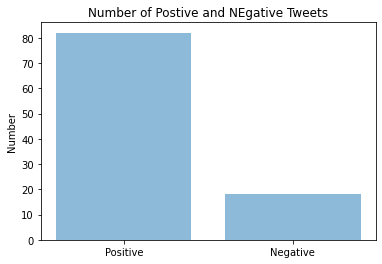

In [25]:
# Visualizing the results
import matplotlib.pyplot as plt
import numpy as np
objects = ['Positive','Negative']
y_pos = np.arange(len(objects))

plt.bar(y_pos,[total_pos,total_neg],alpha=0.5)
plt.xticks(y_pos,objects)
plt.ylabel('Number')
plt.title('Number of Postive and NEgative Tweets')

plt.show()
